## Acquiring the Dataset from Kaggle

In [2]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [3]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 99% 81.0M/82.0M [00:04<00:00, 15.3MB/s]
100% 82.0M/82.0M [00:04<00:00, 19.0MB/s]


## Unzip Dataset

In [4]:
import zipfile,os
local_zip = "garbage-classification.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/")
zip_ref.close()

In [5]:
!pip install split-folders
import splitfolders

In [6]:
splitfolders.ratio("/tmp/Garbage classification/Garbage classification", output="/tmp/Garbage classification/Garbage classification/split", 
                   seed=1337, ratio=(0.8, 0.2))

Copying files: 2527 files [00:00, 5056.82 files/s]


In [10]:
base_dir = "/tmp/Garbage classification/Garbage classification/split"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")

In [11]:
os.listdir(base_dir)

['train', 'val']

In [12]:
#Directory training
train_cardboard = os.path.join(train_dir, "cardboard")
train_glass = os.path.join(train_dir, "glass")
train_metal = os.path.join(train_dir, "metal")
train_paper = os.path.join(train_dir, "paper")
train_plastic = os.path.join(train_dir, "plastic")
train_trash = os.path.join(train_dir, "trash")

#Directory validation
val_cardboard = os.path.join(validation_dir, "cardboard")
val_glass = os.path.join(validation_dir, "glass")
val_metal = os.path.join(validation_dir, "metal")
val_paper = os.path.join(validation_dir, "paper")
val_plastic = os.path.join(validation_dir, "plastic")
val_trash = os.path.join(validation_dir, "trash")

In [13]:
print(os.listdir(train_dir))

['plastic', 'paper', 'metal', 'glass', 'trash', 'cardboard']


In [14]:
print(os.listdir(validation_dir))

['plastic', 'paper', 'metal', 'glass', 'trash', 'cardboard']


## Visualize The Dataset

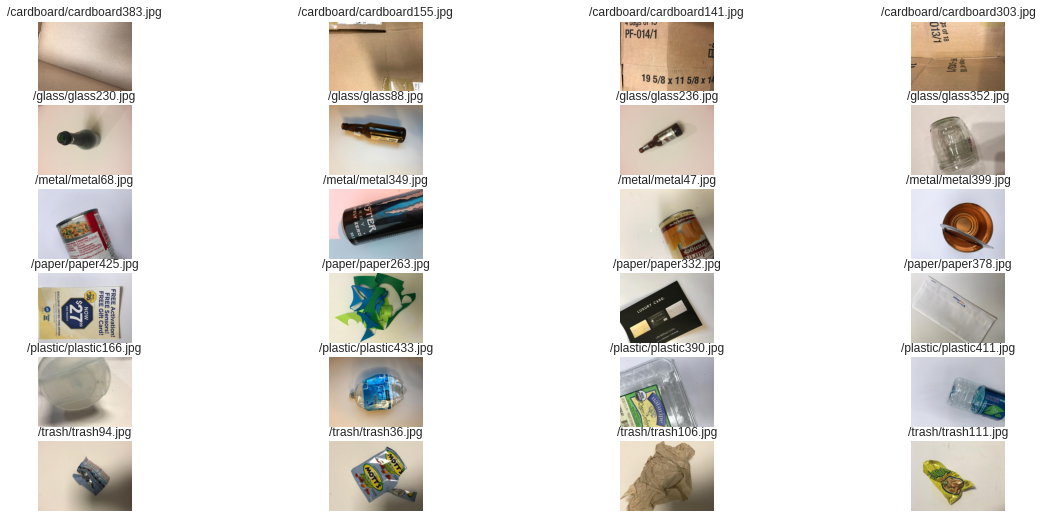

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
plt.style.use("seaborn")
total = 4                                                                       
index = np.random.randint(20)                                                    

plt.figure(figsize=(5*total, 9))

list_cardboard = [os.path.join('/tmp/Garbage classification/Garbage classification/cardboard', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/cardboard')[index:index+total]]
list_glass = [os.path.join('/tmp/Garbage classification/Garbage classification/glass', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/glass')[index:index+total]]
list_metal = [os.path.join('/tmp/Garbage classification/Garbage classification/metal', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/metal')[index:index+total]]
list_paper = [os.path.join('/tmp/Garbage classification/Garbage classification/paper', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/paper')[index:index+total]]
list_plastic = [os.path.join('/tmp/Garbage classification/Garbage classification/plastic', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/plastic')[index:index+total]]
list_trash = [os.path.join('/tmp/Garbage classification/Garbage classification/trash', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/trash')[index:index+total]]
for i, path in enumerate(list_cardboard+list_glass+list_metal+list_paper+list_plastic+list_trash):
  plt.subplot(6, total, i+1)
  plt.axis('off')

  plt.title(path.replace('/tmp/Garbage classification/Garbage classification', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

## Image Data Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.15,
                    #width_shift_range=2.0,
                    #height_shift_range=2.0,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

In [19]:
train_gen = train_datagen.flow_from_directory(
        train_dir,  # Training Directory
        target_size=(224, 224),  # Changing The Picture Resolution
        batch_size=128,
        # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
        validation_dir, # Validation Directory
        target_size=(224, 224), # Changing the picture resolution
        batch_size=128, # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


## Callbacks

In [20]:
import tensorflow as tf

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>=0.99):
      print("\nAccuracy has reached 99%, training stop!")
      self.model.stop_training=True

In [22]:
callbacks = myCallback()

## Transfer Learning

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [24]:
last_layer = pre_trained_model.get_layer("block_16_expand_relu")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 960)


## Build The Model

In [25]:
import tensorflow as tf

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (6, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = "adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [26]:
history = model.fit(train_gen,
                    epochs=50,
                    validation_data = val_gen,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/50
16/16 - 64s - loss: 39.5032 - accuracy: 0.2298 - val_loss: 6.3830 - val_accuracy: 0.4134
Epoch 2/50
16/16 - 31s - loss: 3.9078 - accuracy: 0.4195 - val_loss: 1.2892 - val_accuracy: 0.5925
Epoch 3/50
16/16 - 30s - loss: 1.1731 - accuracy: 0.5973 - val_loss: 0.8231 - val_accuracy: 0.6909
Epoch 4/50
16/16 - 31s - loss: 0.7828 - accuracy: 0.7112 - val_loss: 0.7166 - val_accuracy: 0.7362
Epoch 5/50
16/16 - 30s - loss: 0.6976 - accuracy: 0.7410 - val_loss: 0.6643 - val_accuracy: 0.7598
Epoch 6/50
16/16 - 30s - loss: 0.6264 - accuracy: 0.7697 - val_loss: 0.6203 - val_accuracy: 0.7815
Epoch 7/50
16/16 - 30s - loss: 0.5649 - accuracy: 0.7826 - val_loss: 0.6348 - val_accuracy: 0.7539
Epoch 8/50
16/16 - 30s - loss: 0.4763 - accuracy: 0.8301 - val_loss: 0.5809 - val_accuracy: 0.7972
Epoch 9/50
16/16 - 30s - loss: 0.4465 - accuracy: 0.8306 - val_loss: 0.5561 - val_accuracy: 0.8110
Epoch 10/50
16/16 - 31s - loss: 0.3925 - accuracy: 0.8653 - val_loss: 0.5692 - val_accuracy: 0.8012
Epoch 11

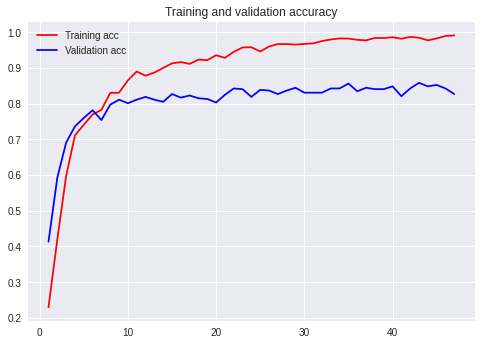

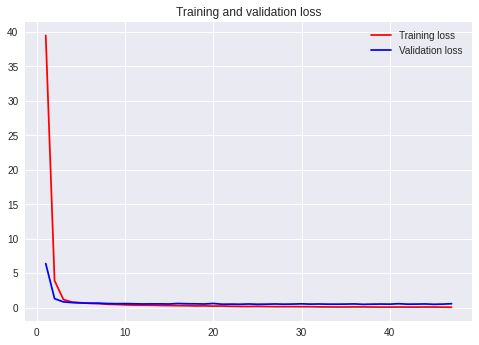

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving 50885730617_467be49f14_k.jpg to 50885730617_467be49f14_k.jpg


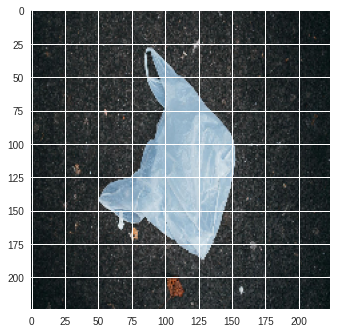

cardboard: 0.16%
glass: 0.00%
metal: 0.03%
paper: 2.52%
plastic: 0.00%
trash: 97.30%


In [28]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

labels = train_gen.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

## Exporting to TF lite

In [29]:
export_dir = 'saved_model/1'
tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [30]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)


In [32]:
converter.optimizations = [optimization]

In [33]:
tflite_model = converter.convert();

In [36]:
tflite_model_file = 'model.tflite'


In [37]:
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [38]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [39]:
try:
    from google.colab import files
    files.download('model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>